# Laboratorium 09 — Explainable AI (XAI) dla klasyfikacji komórek krwi

W tym laboratorium poznamy **metody wyjaśnialności modeli głębokich (Explainable AI, XAI)** na przykładzie prostego modelu klasyfikacji obrazów medycznych. Skupimy się na **wizualizacji tego, na co patrzy model**, gdy podejmuje decyzję.

**Cele:**
- zaimplementować prostą sieć CNN do klasyfikacji komórek krwii na zdjęciach mikroskopowych,
- wygenerować **mapy saliency (gradientowe)**,
- zaimplementować i zastosować **Grad-CAM**,
- nauczyć się interpretować heatmapy: czy model patrzy na obszar anatomicznie sensowny,
- spróbować zmienić interpretację sieci (adversarial attack).

**Dataset:** `BloodMNIST` ze zbioru **MedMNIST** — zestaw obrazów mikroskopowych komórek krwi (8 klas różnych typów komórek). Dataset zawiera następujące typy komórek krwi:

0. Basophil
1. Eosinophil
2. Erythroblast
3. Immature Granulocytes (IG)
4. Lymphocyte
5. Monocyte
6. Neutrophil
7. Platelet


## 0. Importy i konfiguracja

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics.classification import Accuracy, AUROC

import medmnist
from medmnist import INFO

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

if torch.cuda.is_available():
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('medium')

/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


### Zadanie 1: Implementacja DataModule

Stwórz klasę `PneumoniaDataModule` dziedziczącą po `LightningDataModule`, która będzie odpowiadać za wczytywanie danych z datasetu BloodMNIST. Możesz wzorować się na modułąch implementowanych w ramach wcześniejszych laboratoriów. Wczytaj dane kolorowe w formacie RGB (argument `as_rgb=True`).

Sprawdź rozmiar wczytywanych batchy.

In [2]:
DATA_FLAG = 'bloodmnist'
DOWNLOAD_ROOT = './data'

info = INFO[DATA_FLAG]
n_classes = len(info['label'])

print('Dataset:', info['description'])
print('Liczba klas:', n_classes)
print('Etykiety:', info['label'])


Dataset: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
Liczba klas: 8
Etykiety: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


In [3]:
class PneumoniaDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = "./data",
        batch_size: int = 64,
        num_workers: int = 4
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ])

    def prepare_data(self):
        # Pobranie danych (wykonywane tylko raz)
        medmnist.BloodMNIST(
            split="train",
            download=True,
            root=self.data_dir,
            as_rgb=True
        )

    def setup(self, stage=None):
        self.train_dataset = medmnist.BloodMNIST(
            split="train",
            root=self.data_dir,
            transform=self.transform,
            as_rgb=True
        )

        self.val_dataset = medmnist.BloodMNIST(
            split="val",
            root=self.data_dir,
            transform=self.transform,
            as_rgb=True
        )

        self.test_dataset = medmnist.BloodMNIST(
            split="test",
            root=self.data_dir,
            transform=self.transform,
            as_rgb=True
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

In [4]:
datamodule = PneumoniaDataModule(batch_size=32)
datamodule.prepare_data()
datamodule.setup()

batch = next(iter(datamodule.train_dataloader()))
images, labels = batch

print("Rozmiar batcha (obrazy):", images.shape)
print("Rozmiar batcha (etykiety):", labels.shape)

Rozmiar batcha (obrazy): torch.Size([32, 3, 28, 28])
Rozmiar batcha (etykiety): torch.Size([32, 1])


### Zadanie 2: Podgląd przykładowych obrazów

Wyświetl kilka przykładowych obrazów w przetwarzanym zbiorze razem z ich etykietami.

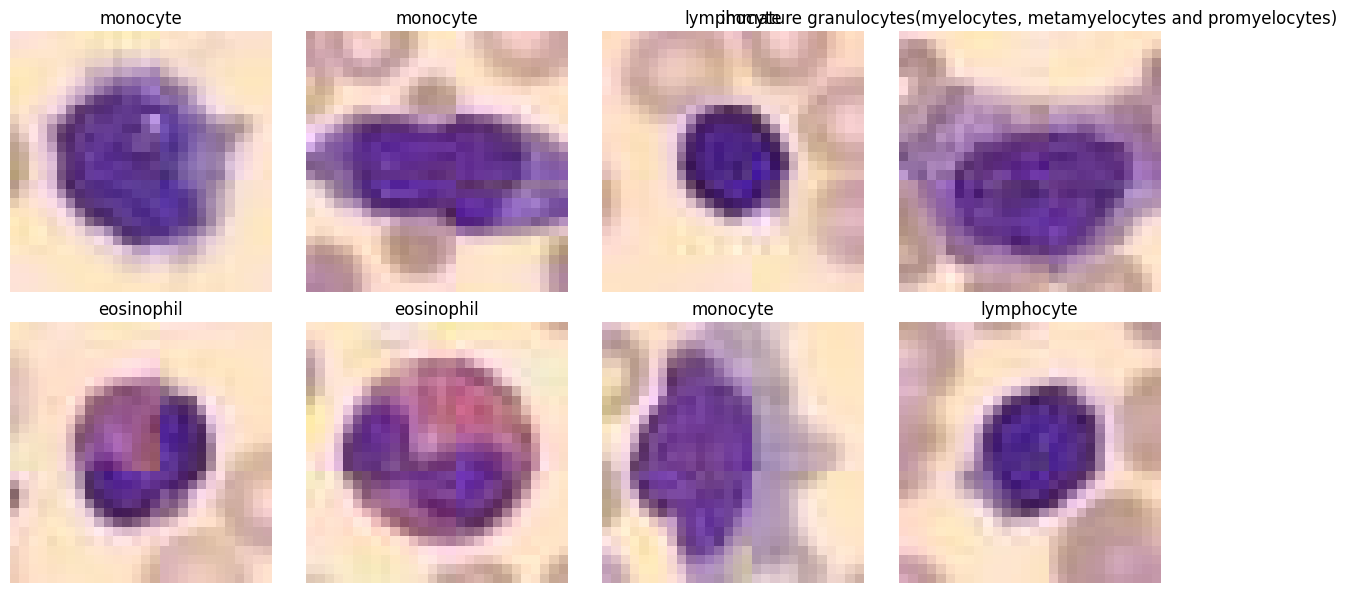

In [5]:
datamodule = PneumoniaDataModule(batch_size=8)
datamodule.prepare_data()
datamodule.setup()

images, labels = next(iter(datamodule.train_dataloader()))

labels = labels.squeeze()

label_names = INFO[DATA_FLAG]['label']

images = images * 0.5 + 0.5

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    label = int(labels[i])

    ax.imshow(img)
    ax.set_title(f"{label_names[str(label)]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Zadanie 3: Implementacja architektury CNN

**Klasa `SimpleCNN(nn.Module)`**

Zaimplementuj architekturę prostej sieci konwolucyjnej do zadania klasyfikacji. Niech zaprojektowana sieć ma około miliona parametrów.
Dla wykorzystywanego datasetu powinno to pozwolić na osiągnięcie powyżej 95% dokładności na zbiorze testowym. Możesz się wzorować na sieciach z wcześniejszych laboratoriów.

**Klasa `LightningSimpleCNN(LightningModule)`**

Podobnie jak we wcześniejszych ćwiczeniach, stwórz klasę dziedziczącą po `LightningModule`, która będzie zarządzać treningiem, jego parametrami i logować przebiej treningu.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 8):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 28 -> 14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 14 -> 7

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
class LightningSimpleCNN(LightningModule):
    def __init__(
        self,
        num_classes: int = 8,
        lr: float = 1e-3
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = SimpleCNN(num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()

        logits = self(x)
        loss = self.loss_fn(logits, y)

        acc = self.train_acc(logits, y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()

        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_acc(logits, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()

        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.test_acc(logits, y)

        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [8]:
model = LightningSimpleCNN(num_classes=n_classes)
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Liczba parametrów: {total_params:,}")

LightningSimpleCNN(
  (model): SimpleCNN(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=3136, out_features=256, bias=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=8, bias=True)
    )
  )
  (loss_fn): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)
Liczba parametrów: 828,712


### Zadanie 4: Trening modelu

Przeprowadź trening zdefiniowanego modelu. Pamiętaj, żeby zapisywać model o njalepszym wyniku na zbiorze walidacyjnym.

In [9]:
# DataModule
datamodule = PneumoniaDataModule(
    batch_size=64,
    num_workers=4
)

# Model
model = LightningSimpleCNN(
    num_classes=n_classes,
    lr=1e-3
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="best-model-{epoch:02d}-{val_acc:.4f}"
)

early_stopping_callback = EarlyStopping(
    monitor="val_acc",
    mode="max",
    patience=5,
    verbose=True
)


trainer = Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.fit(model, datamodule=datamodule)

print("Najlepszy model zapisany w:")
print(checkpoint_callback.best_model_path)

print("Najlepsza val_acc:")
print(checkpoint_callback.best_model_score)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | SimpleCNN          | 828 K  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
828 K     Trainable params
0         Non-trainable params
828 K     Total params
3.315     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 187/187 [00:01<00:00, 146.46it/s, v_num=1, train_loss=0.777, train_acc=0.691, val_loss=0.524, val_acc=0.809]

Metric val_acc improved. New best score: 0.809


Epoch 1: 100%|██████████| 187/187 [00:00<00:00, 192.52it/s, v_num=1, train_loss=0.372, train_acc=0.873, val_loss=0.446, val_acc=0.845]

Metric val_acc improved by 0.036 >= min_delta = 0.0. New best score: 0.845


Epoch 2: 100%|██████████| 187/187 [00:00<00:00, 191.58it/s, v_num=1, train_loss=0.268, train_acc=0.909, val_loss=0.346, val_acc=0.876]

Metric val_acc improved by 0.030 >= min_delta = 0.0. New best score: 0.876


Epoch 3: 100%|██████████| 187/187 [00:00<00:00, 203.82it/s, v_num=1, train_loss=0.160, train_acc=0.945, val_loss=0.299, val_acc=0.893]

Metric val_acc improved by 0.017 >= min_delta = 0.0. New best score: 0.893


Epoch 4: 100%|██████████| 187/187 [00:00<00:00, 187.47it/s, v_num=1, train_loss=0.231, train_acc=0.909, val_loss=0.270, val_acc=0.902] 

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.902


Epoch 5: 100%|██████████| 187/187 [00:00<00:00, 192.55it/s, v_num=1, train_loss=0.199, train_acc=0.945, val_loss=0.266, val_acc=0.910] 

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.910


Epoch 6: 100%|██████████| 187/187 [00:01<00:00, 183.83it/s, v_num=1, train_loss=0.134, train_acc=0.964, val_loss=0.234, val_acc=0.921] 

Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.921


Epoch 8: 100%|██████████| 187/187 [00:00<00:00, 194.63it/s, v_num=1, train_loss=0.318, train_acc=0.927, val_loss=0.212, val_acc=0.926] 

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.926


Epoch 10: 100%|██████████| 187/187 [00:00<00:00, 197.93it/s, v_num=1, train_loss=0.197, train_acc=0.909, val_loss=0.206, val_acc=0.930] 

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.930


Epoch 14: 100%|██████████| 187/187 [00:01<00:00, 185.21it/s, v_num=1, train_loss=0.0758, train_acc=0.982, val_loss=0.204, val_acc=0.941]

Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.941


Epoch 19: 100%|██████████| 187/187 [00:00<00:00, 197.59it/s, v_num=1, train_loss=0.111, train_acc=0.964, val_loss=0.215, val_acc=0.946]  

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.946


Epoch 24: 100%|██████████| 187/187 [00:00<00:00, 206.72it/s, v_num=1, train_loss=0.0159, train_acc=1.000, val_loss=0.261, val_acc=0.939] 

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.946. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 187/187 [00:00<00:00, 206.43it/s, v_num=1, train_loss=0.0159, train_acc=1.000, val_loss=0.261, val_acc=0.939]
Najlepszy model zapisany w:
/home/karolina/studia/piaom/lab9/lightning_logs/version_1/checkpoints/best-model-epoch=19-val_acc=0.9457.ckpt
Najlepsza val_acc:
tensor(0.9457, device='cuda:0')


### Zadanie 5: Test najlepszego modelu

Wczytaj najlepszy model i przeprowadź jego ewaluację na zbiorze testowym.

In [11]:
trainer.test(
    model=model,
    datamodule=datamodule,
    ckpt_path="best"
)

Restoring states from the checkpoint path at /home/karolina/studia/piaom/lab9/lightning_logs/version_1/checkpoints/best-model-epoch=19-val_acc=0.9457.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/karolina/studia/piaom/lab9/lightning_logs/version_1/checkpoints/best-model-epoch=19-val_acc=0.9457.ckpt


Testing DataLoader 0: 100%|██████████| 54/54 [00:00<00:00, 398.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9330605268478394     │
│         test_loss         │    0.24346725642681122    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.24346725642681122, 'test_acc': 0.9330605268478394}]

## Explainable AI — wprowadzenie

W kontekście sieci CNN do klasyfikacji obrazów medycznych chcemy odpowiedzieć na pytanie:

> **Które piksele/regiony obrazu najbardziej wpływają na decyzję modelu?**

**Dlaczego XAI jest ważne w medycynie?**
- Trzeba rozumieć, dlaczego model podjął daną decyzję
- Wykrywanie błędnych wzorców (np. model patrzy na znaczniki zamiast na tkankę)
- Model może nauczyć się cech, których nie byliśmy świadomi
- Wymogi prawne dotyczące wyjaśnialności systemów AI w medycynie

### Saliency Maps (mapy czułości)
**Idea:** Gradient wyjścia względem wejścia pokazuje, które piksele najbardziej wpływają na predykcję.

**Matematyka:**
$$\text{Saliency}(x) = \left|\frac{\partial y_c}{\partial x}\right|$$

gdzie:
- $x$ — obraz wejściowy
- $y_c$ — logit/wyjście dla klasy $c$
- duża wartość gradientu → duży wpływ piksela na wynik

**Zalety:**
- Prosta implementacja
- Rozdzielczość odpowiada rozmiarowi wejścia
- Pokazuje lokalne zmiany

**Wady:**
- Może być zaszumiona
- Trudna do interpretacji w złożonych modelach
- Wrażliwa na małe perturbacje

### Grad-CAM (Gradient-weighted Class Activation Mapping)
**Idea:** Wykorzystuje gradienty względem **aktywacji ostatniej warstwy konwolucyjnej**, aby stworzyć mapę ciepła pokazującą, które regiony są ważne.

**Matematyka:**
$$\alpha_k = \frac{1}{Z}\sum_{i,j} \frac{\partial y_c}{\partial A^k_{ij}}$$
$$\text{Grad-CAM} = \text{ReLU}\left(\sum_k \alpha_k \cdot A^k\right)$$

gdzie:
- $A^k$ — aktywacje k-tego kanału ostatniej warstwy konwolucyjnej
- $\alpha_k$ — waga kanału k (średni gradient)
- ReLU — usuwamy negatywne wpływy

**Zalety:**
- Wyższa jakość wizualizacji (mniej szumu)
- Pokazuje regiony, nie pojedyncze piksele

**Wady:**
- Niższa rozdzielczość (wymaga interpolacji do wejściowego rozmiaru)
- Zależy od wyboru warstwy konwolucyjnej
- Może pomijać drobne detale

**Proces zastosowania XAI:**
1. Wybieramy obraz z zestawu walidacyjnego/testowego
2. Sprawdzamy predykcję modelu
3. Generujemy mapy saliency i Grad-CAM
4. Krytycznie interpretujemy czy model patrzy na prawidłowe cechy anatomiczne

### Zadanie 6: Pobranie danych do wizualizacji

In [12]:
val_loader = datamodule.val_dataloader()
val_batch = next(iter(val_loader))
val_images = val_batch[0].to(DEVICE)
val_labels = val_batch[1].long().view(-1).to(DEVICE)

val_images.shape, val_labels.shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

### Zadanie 7: Mapa saliency

Stwórz funkcję `compute_saliency_map`.

1. Jej argumentami są: model (nauczona sieć), obraz wejściowy i ewentualną docelową klasę, względem której będzie sprawdzany gradient.
2. Ustaw model w tryb ewaluacji: `model.eval()`.
3. Włącz obliczanie gradientów dla obrazu: `image = image.to(DEVICE).requires_grad_(True)`.
4. Wyczyść gradienty (`model.zero_grad()`) oraz przepuść obraz przez sieć.
5. Jeśli nie została podana docelowa klasa jako argument, to wybierz klasę wyznaczoną przez sieć dla pierwszego elementu batcha: `logits.argmax(dim=1)[0].item()`.
6. Przypisz wynik sieci dla tej klasy (logit) do nowej zmiennej.
7. Wyznacz gradienty względem tego wyniku: `.backward()`.
8. Pobierz wartość bezwzględną gradientu wyniku względem obrazu wejściowego: `.grad.data.abs()`.
9. Oblicz normę L2 obliczonych gradientów względem kanałów obrazu wejściowego: `torch.norm`.
10. Dla wyniku wykonaj `.detach().cpu().numpy().squeeze()`. Zwróć otrzymaną wartość.
11. Funkcja `plot_saliency` do wizualizacji jest już zaimplementowana.
12. Poza funkcjami wybierz jeden obraz wejściowy: `val_images[idx:idx+1]` (zakres jest potrzebny, żeby zachować wymiar batcha), `val_labels[idx].item()`.
13. Wywołaj zaimplementowane funkcje dla tych danych.
14. Zinterpretuj wyniki.

**Jak interpretować wyniki?**
- Jasne/gorące obszary - piksele o dużym wpływie na decyzję
- Sprawdź czy model patrzy na komórkę czy na tło?
- Oceń czy wyróżnione obszary mają sens?

In [13]:
def compute_saliency_map(model, image, target_class=None):
    """
    model: wytrenowany model (LightningModule lub nn.Module)
    image: tensor [1, C, H, W]
    target_class: int lub None
    """
    model = model.to(DEVICE)
    model.eval()

    # obraz z gradientami
    image = image.to(DEVICE).requires_grad_(True)

    # wyczyszczenie gradientów
    model.zero_grad()

    # forward
    logits = model(image)

    # wybór klasy
    if target_class is None:
        target_class = logits.argmax(dim=1)[0].item()

    # logit dla wybranej klasy
    score = logits[0, target_class]

    # backward – gradient względem obrazu
    score.backward()

    # |∂score / ∂image|
    gradients = image.grad.data.abs()

    # norma L2 po kanałach
    saliency = torch.norm(gradients, dim=1)

    # do numpy
    saliency = saliency.detach().cpu().numpy().squeeze()

    return saliency


def plot_saliency(image, saliency):
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
    if isinstance(saliency, torch.Tensor):
        saliency = saliency.detach().cpu().numpy()

    image = image.squeeze().transpose(1, 2, 0)
    saliency = saliency.squeeze()

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Obraz")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap="hot")
    plt.title("Mapa saliency")
    plt.axis("off")

    plt.show()

Prawdziwa etykieta: lymphocyte


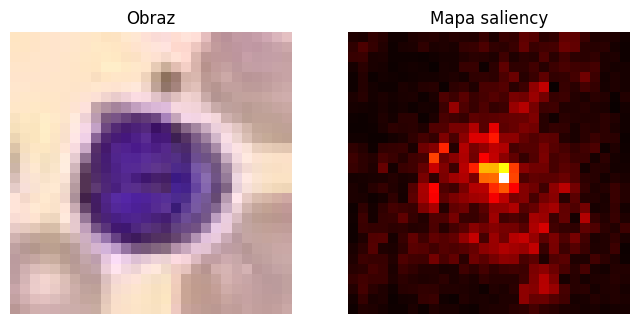

In [14]:
# Pobranie zbioru walidacyjnego
val_loader = datamodule.val_dataloader()
val_images, val_labels = next(iter(val_loader))

idx = 0  # możesz zmienić
image = val_images[idx:idx+1]
label = val_labels[idx].item()

print("Prawdziwa etykieta:", INFO[DATA_FLAG]['label'][str(label)])

saliency_map = compute_saliency_map(
    model=model,
    image=image,
    target_class=None  # klasa przewidziana przez model
)

img_vis = image * 0.5 + 0.5

plot_saliency(img_vis, saliency_map)

### Zadanie 8: Grad-CAM

1. Znajdź ostatnią warstwę konwolucyjną:

```
best_model_copy = copy.deepcopy(best_model)
conv_layers = [m for m in best_model_Copy.model.features.modules() if isinstance(m, nn.Conv2d)]
cam_layer = conv_layers[-1]
```

2. Przygotuj zmienne globalne:
- `global activation, gradients`
- `activation = None` — przechowa aktywacje z forward pass
- `gradients = None` — przechowa gradienty z backward pass

3. Stwórz funkcję `forward_hook`:

```
def forward_hook(module, input, output):
    global activation
    activation = output
```

4. Stwórz funkcję `backward hook`:

```
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]
```

5. Następnie zarejestruj te funkcje:

```
cam_layer.register_forward_hook(forward_hook)
cam_layer.register_full_backward_hook(backward_hook)
```

6. Zaimplementuj funkcję `compute_gradcam`:
  - Jej argumentami są: model (nauczona sieć), obraz wejściowy i ewentualną docelową klasę, względem której będzie sprawdzany gradient.
  - Ustaw model w tryb ewaluacji: `model.eval()`.
  - Włącz obliczanie gradientów dla obrazu: `image = image.to(DEVICE).requires_grad_(True)`.
  - Wyczyść gradienty (`model.zero_grad()`) oraz przepuść obraz przez sieć.
  - Jeśli nie została podana docelowa klasa jako argument, to wybierz klasę wyznaczoną przez sieć dla pierwszego elementu batcha: `logits.argmax(dim=1)[0].item()`.
  - Przypisz wynik sieci dla tej klasy (logit) do nowej zmiennej.
  - Wyznacz gradienty względem tego wyniku: `.backward()`.
  - Pobierz wartości globalnych zmiennych i sprawdź czy mają przypisane wartości (nie są `None`) oraz wykonaj dla nich `.detach()`.
  - Oblicz średni gradient dla każdego kanału: `weights = grad.mean(dim=[2, 3], keepdim=True)`.
  - Przemnóż aktywacje przez wagi i zsumuj względem kanałów: `cam = (weights * act).sum(dim=1, keepdim=True)`.
  - Następnie oblicz ReLU na podstawie wyjścia: `cam = F.relu(cam)`.
  - Usuń wymiar batcha i kanałów: `cam = cam[0, 0]`.
  - Znormalizuj zakres danych do [0; 1].

7. Funkcja do wyświetlenia wyniku `plot_gradcam` jest już zaimplementowana.

8. Elementy poza tymi funkcjami są takie same jak dla poprzedniego zadania (mapa saliency).

**Jak interpretować wyniki?**
- Czy model koncentruje się na komórce czy na tle?
- Czy podświetlone obszary odpowiadają charakterystycznym cechom danej klasy komórek?
- Czy model "patrzy" na artefakty obrazu (plamy, zniekształcenia)?

In [19]:
import copy

best_model_copy = copy.deepcopy(model)
best_model_copy = best_model_copy.to(DEVICE)

conv_layers = [
    m for m in best_model_copy.model.features.modules()
    if isinstance(m, nn.Conv2d)
]

cam_layer = conv_layers[-1]
print("Używana warstwa CAM:", cam_layer)

activation = None
gradients = None

def forward_hook(module, input, output):
    global activation
    activation = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

cam_layer.register_forward_hook(forward_hook)
cam_layer.register_full_backward_hook(backward_hook)


def compute_gradcam(model, image, target_class=None):
    global activation, gradients

    model.eval()
    model = model.to(DEVICE)

    image = image.to(DEVICE).requires_grad_(True)

    model.zero_grad()
    activation = None
    gradients = None

    # forward
    logits = model(image)

    # wybór klasy
    if target_class is None:
        target_class = logits.argmax(dim=1)[0].item()

    score = logits[0, target_class]

    # backward
    score.backward()

    # sprawdzenie hooków
    if activation is None or gradients is None:
        raise RuntimeError("Hooki nie zadziałały - brak aktywacji lub gradientów")

    act = activation.detach()
    grad = gradients.detach()

    # średni gradient po H,W
    weights = grad.mean(dim=[2, 3], keepdim=True)

    # ważona suma map cech
    cam = (weights * act).sum(dim=1, keepdim=True)

    # ReLU
    cam = F.relu(cam)

    # usunięcie batcha i kanału
    cam = cam[0, 0]

    # normalizacja do [0, 1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    return cam


def plot_gradcam(image, cam):
    img = image.detach().cpu().numpy().squeeze()
    cam = cam.detach().cpu().numpy().squeeze()
    
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    
    img = np.transpose(img, (1, 2, 0))
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(img)
    axs[0].set_title('Oryginalny obraz')
    axs[0].axis('off')

    im1 = axs[1].imshow(cam, cmap='hot')
    axs[1].set_title('Grad-CAM')
    axs[1].axis('off')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    axs[2].imshow(img)
    axs[2].imshow(cam, cmap='jet', alpha=0.5)
    axs[2].set_title('Nakładka Grad-CAM')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()



Używana warstwa CAM: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


Prawdziwa etykieta: lymphocyte


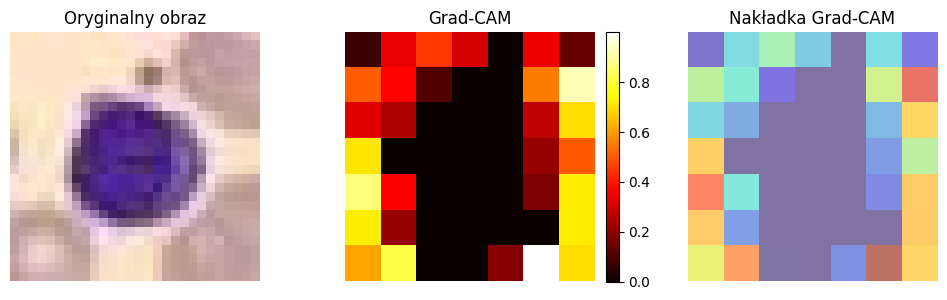

In [20]:
val_loader = datamodule.val_dataloader()
val_images, val_labels = next(iter(val_loader))

idx = 0
image = val_images[idx:idx+1]
label = val_labels[idx].item()

print(
    "Prawdziwa etykieta:",
    INFO[DATA_FLAG]['label'][str(label)]
)

cam = compute_gradcam(
    model=best_model_copy,
    image=image,
    target_class=None   # klasa przewidziana przez model
)

plot_gradcam(image, cam)


### Zadanie 9: Adversarial Attack — sprawdzenie odporności modelu

Adversarial example to obraz, który został nieznacznie zmodyfikowany w sposób, który jest niewidoczny dla człowieka, ale całkowicie zmienia predykcję modelu.

Dlaczego to ważne w medycynie?
- Testowanie odporności systemów AI
- Bezpieczeństwo: czy model jest podatny na manipulacje?
- Czy można ufać predykcjom w krytycznych przypadkach?

Rodzaje ataków:

Untargeted Attack - zmienia predykcję na dowolną inną klasę

Targeted Attack - zmienia predykcję na konkretną wybraną klasę

1. Zaimplementuj funkcję `create_adversarial_perturbation`:
  - Jej argumentami są: wytrenowany model, obraz wejściowy, prawdziwa klasa obrazu, maksymalna dozwolona modyfikacja (np. 0.15), learning rate dla optymalizacji (np. 0.01), liczba iteracji optymalizacji i opcjonalna klasa docelowa (w przypadku targeted attack).
  - Przełącz model w tryb ewaluacji.
  - Skopiuj obraz wejściowy: `original_image = image.clone().detach().to(DEVICE)`.
  - Stwórz macierz zmian obrazu: `torch.zeros_like(original_image, requires_grad=True, device=DEVICE)`.
  - Przygotuj optymalizator: `torch.optim.Adam([perturbation], lr=lr)`
  - Stwórz słownik do zapamiętania historii optymalizacji: `history = {'loss': [], 'pred_class': [], 'true_prob': [], 'perturbation_norm': []}`
  - Zaimplementuj pętlę optymalizacyjną:
    - Stwórz nowy obraz wejściowy (dodanie zmian do oryginalnego).
    - Obetnij wartości do zakresu [-1, 1].
    - Oblicz wyjście modelu.
    - Wyznacz prawdopodobieństwa klas za pomocą `torch.softmax(logits, dim=1)`.
    - W przypadku targeted attack strata to `F.cross_entropy(logits, torch.tensor([target_class], device=DEVICE))`.
    - W przypadku untargeted attack strata to `-F.cross_entropy(logits, torch.tensor([true_class], device=DEVICE))`.
    - Dodaj regularyzację do funkcji straty: `torch.mean(perturbation ** 2)` - ma spowodować, że modyfikacja będzie jak najmniejsza.
    - Obetnij zmieny do zakresu [-epsilon, epsilon] wewnątrz bloku `with torch.no_grad():`.
    - Sprawdź przewidywanie modelu dla zmodyfikowanego wejścia `.argmax(dim=1).item()`.
    - Zaktualizuj historię.
    - Na koniec pętli wykonaj iterację optymalziacji: `loss.backward()` i `optimizer.step()`.
  - Poza pętlą obetnij zmiany i wynikowy obraz do założonego zakresu (jak wcześniej).
  - Zwróć zmiany, zmodyfikowany obraz i historię.

  2. Funkcja do wizualizacji jest już zaimplementowana. Jej argumentami są: oryginalny obraz, zmodyfikowany obraz, modyfikację obrazu, prawdziwą klasę, oryginalne przewidywanie, zmodyfikowane przewidywanie, oryginalne prawdopodobieństwo, zmodyfikowane prawdopodobieństwo i historię.

  3. Wybierz próbkę, która została sklasyfikowana prawidłowo.

  ```
  for idx in range(len(val_images)):
    sample_image = val_images[idx:idx+1]
    true_label = val_labels[idx].item()
    
    with torch.no_grad():
        logits_orig = best_model(sample_image)
        pred_orig = logits_orig.argmax(dim=1).item()
    
    if pred_orig == true_label:
        print(f"Znaleziono próbkę {idx}: klasa {true_label}")
        break
  ```
  
  4. Sprawdź wynik modelu dla oryginalnych danych.

  ```
  with torch.no_grad():
    logits_orig = best_model(sample_image)
    probs_orig = torch.softmax(logits_orig, dim=1)
    prob_orig = probs_orig[0, pred_orig].item()
  ```

  5. Wykorzystaj zaimplementowaną funkcje do stworzenia zmodyfikowanego wejścia.

  6. Sprawdź wynik modelu dla zmodyfikowanego wejścia.

  ```
  with torch.no_grad():
    logits_adv = best_model(adv_image)
    probs_adv = torch.softmax(logits_adv, dim=1)
    pred_adv = logits_adv.argmax(dim=1).item()
    prob_adv = probs_adv[0, pred_adv].item()
  ```

  7. Zwizualizuj wynik za pomocą funkcji `visualize_adversarial_attack`.

  8. Wybierz konkretną klasę jako cel, wykonaj targeted attack i wyświetl wyniki.

  9. Poeksperymentuj z parametrami.

**Podsumowanie**
  - Czy model zmienił predykcję?
  - Po ilu iteracjach nastąpiła zmiana? (sprawdź wykresy)
  - Jaka jest końcowa pewność modelu?
  - Czy perturbacja jest widoczna gołym okiem na obrazie?
  - Czy różnica ×10 pokazuje strukturalne zmiany czy losowy szum?
  - Co oznacza podatność modelu na adversarial attacks dla zastosowań klinicznych?

**Zadania dodatkowe:** 
- Wygeneruj Grad-CAM dla adversarial image — na co teraz patrzy model?
- Porównaj saliency maps dla oryginalnego i adversarial obrazu

In [21]:
def create_adversarial_perturbation(
    model,
    image,
    true_class,
    epsilon=0.15,
    lr=0.01,
    num_iters=100,
    target_class=None
):
    model.eval()
    model = model.to(DEVICE)

    # oryginalny obraz
    original_image = image.clone().detach().to(DEVICE)

    # perturbacja
    perturbation = torch.zeros_like(
        original_image, requires_grad=True, device=DEVICE
    )

    optimizer = torch.optim.Adam([perturbation], lr=lr)

    history = {
        'loss': [],
        'pred_class': [],
        'true_prob': [],
        'perturbation_norm': []
    }

    for i in range(num_iters):
        optimizer.zero_grad()

        # nowy obraz
        adv_image = original_image + perturbation
        adv_image = torch.clamp(adv_image, -1.0, 1.0)

        logits = model(adv_image)
        probs = torch.softmax(logits, dim=1)

        pred_class = logits.argmax(dim=1).item()
        true_prob = probs[0, true_class].item()

        # loss
        if target_class is not None:
            # targeted attack
            loss_cls = F.cross_entropy(
                logits,
                torch.tensor([target_class], device=DEVICE)
            )
        else:
            # untargeted attack
            loss_cls = -F.cross_entropy(
                logits,
                torch.tensor([true_class], device=DEVICE)
            )

        # regularizacja
        loss_reg = torch.mean(perturbation ** 2)
        loss = loss_cls + 0.1 * loss_reg

        loss.backward()
        optimizer.step()

        # ograniczenie perturbacji
        with torch.no_grad():
            perturbation.clamp_(-epsilon, epsilon)

        # historia
        history['loss'].append(loss.item())
        history['pred_class'].append(pred_class)
        history['true_prob'].append(true_prob)
        history['perturbation_norm'].append(
            perturbation.abs().max().item()
        )

    # finalne obcięcie
    with torch.no_grad():
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        adv_image = torch.clamp(original_image + perturbation, -1.0, 1.0)

    return perturbation.detach(), adv_image.detach(), history

In [22]:
val_loader = datamodule.val_dataloader()
val_images, val_labels = next(iter(val_loader))

for idx in range(len(val_images)):
    sample_image = val_images[idx:idx+1]
    true_label = val_labels[idx].item()

    with torch.no_grad():
        logits_orig = model(sample_image.to(DEVICE))
        pred_orig = logits_orig.argmax(dim=1).item()

    if pred_orig == true_label:
        print(f"Znaleziono próbkę {idx}: klasa {true_label}")
        break

with torch.no_grad():
    logits_orig = model(sample_image.to(DEVICE))
    probs_orig = torch.softmax(logits_orig, dim=1)
    prob_orig = probs_orig[0, pred_orig].item()

Znaleziono próbkę 0: klasa 4


In [23]:

def visualize_adversarial_attack(original_image, adv_image, perturbation, 
                                  true_class, pred_orig, pred_adv, 
                                  prob_orig, prob_adv, history):
    
    fig = plt.figure(figsize=(14, 8))
    
    def denorm(img):
        img = img.detach().cpu().numpy().squeeze()
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        return np.transpose(img, (1, 2, 0))
    
    orig_img = denorm(original_image)
    adv_img = denorm(adv_image)
    
    pert = perturbation.detach().cpu().numpy().squeeze()
    pert = np.transpose(pert, (1, 2, 0))
    
    ax1 = fig.add_subplot(2, 4, 1)
    ax1.imshow(orig_img)
    ax1.set_title(f'Oryginał\nKlasa: {true_class}\nPred: {pred_orig} (p={prob_orig:.3f})')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(2, 4, 2)
    pert_vis = (pert - pert.min()) / (pert.max() - pert.min() + 1e-8)
    ax2.imshow(pert_vis)
    ax2.set_title(f'Perturbacja\nmax|δ|={np.abs(pert).max():.4f}')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(2, 4, 3)
    ax3.imshow(adv_img)
    ax3.set_title(f'Adversarial\nPred: {pred_adv} (p={prob_adv:.3f})')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(2, 4, 4)
    diff = np.abs(adv_img - orig_img) * 10
    diff = np.clip(diff, 0, 1)
    ax4.imshow(diff)
    ax4.set_title('|Różnica| × 10')
    ax4.axis('off')
    
    ax5 = fig.add_subplot(2, 4, 5)
    ax5.plot(history['loss'])
    ax5.set_xlabel('Iteracja')
    ax5.set_ylabel('Loss')
    ax5.set_title('Funkcja straty')
    ax5.grid(True)
    
    ax6 = fig.add_subplot(2, 4, 6)
    ax6.plot(history['true_prob'])
    ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax6.set_xlabel('Iteracja')
    ax6.set_ylabel('P(true_class)')
    ax6.set_title('Prawdopodobieństwo prawdziwej klasy')
    ax6.grid(True)
    
    ax7 = fig.add_subplot(2, 4, 7)
    ax7.plot(history['pred_class'], 'o-', markersize=2)
    ax7.axhline(y=true_class, color='g', linestyle='--', label='Prawdziwa klasa')
    ax7.set_xlabel('Iteracja')
    ax7.set_ylabel('Predykcja')
    ax7.set_title('Zmiana predykcji')
    ax7.legend()
    ax7.grid(True)
    
    ax8 = fig.add_subplot(2, 4, 8)
    ax8.plot(history['perturbation_norm'])
    ax8.set_xlabel('Iteracja')
    ax8.set_ylabel('max|δ|')
    ax8.set_title('Norma perturbacji (L∞)')
    ax8.grid(True)
    
    plt.tight_layout()
    plt.show()


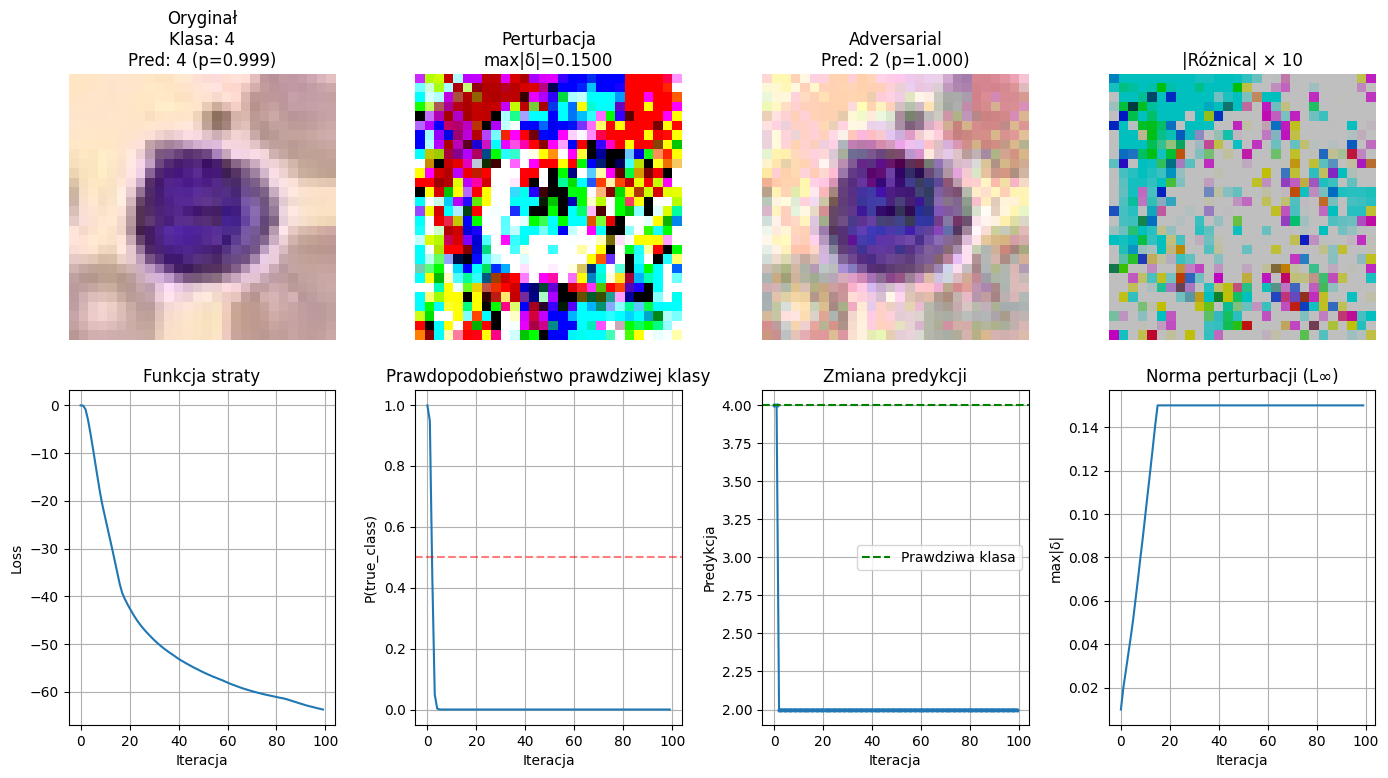

In [24]:
perturbation, adv_image, history = create_adversarial_perturbation(
    model=model,
    image=sample_image,
    true_class=true_label,
    epsilon=0.15,
    lr=0.01,
    num_iters=100,
    target_class=None
)

with torch.no_grad():
    logits_adv = model(adv_image)
    probs_adv = torch.softmax(logits_adv, dim=1)
    pred_adv = logits_adv.argmax(dim=1).item()
    prob_adv = probs_adv[0, pred_adv].item()


visualize_adversarial_attack(
    original_image=sample_image,
    adv_image=adv_image,
    perturbation=perturbation,
    true_class=true_label,
    pred_orig=pred_orig,
    pred_adv=pred_adv,
    prob_orig=prob_orig,
    prob_adv=prob_adv,
    history=history
)

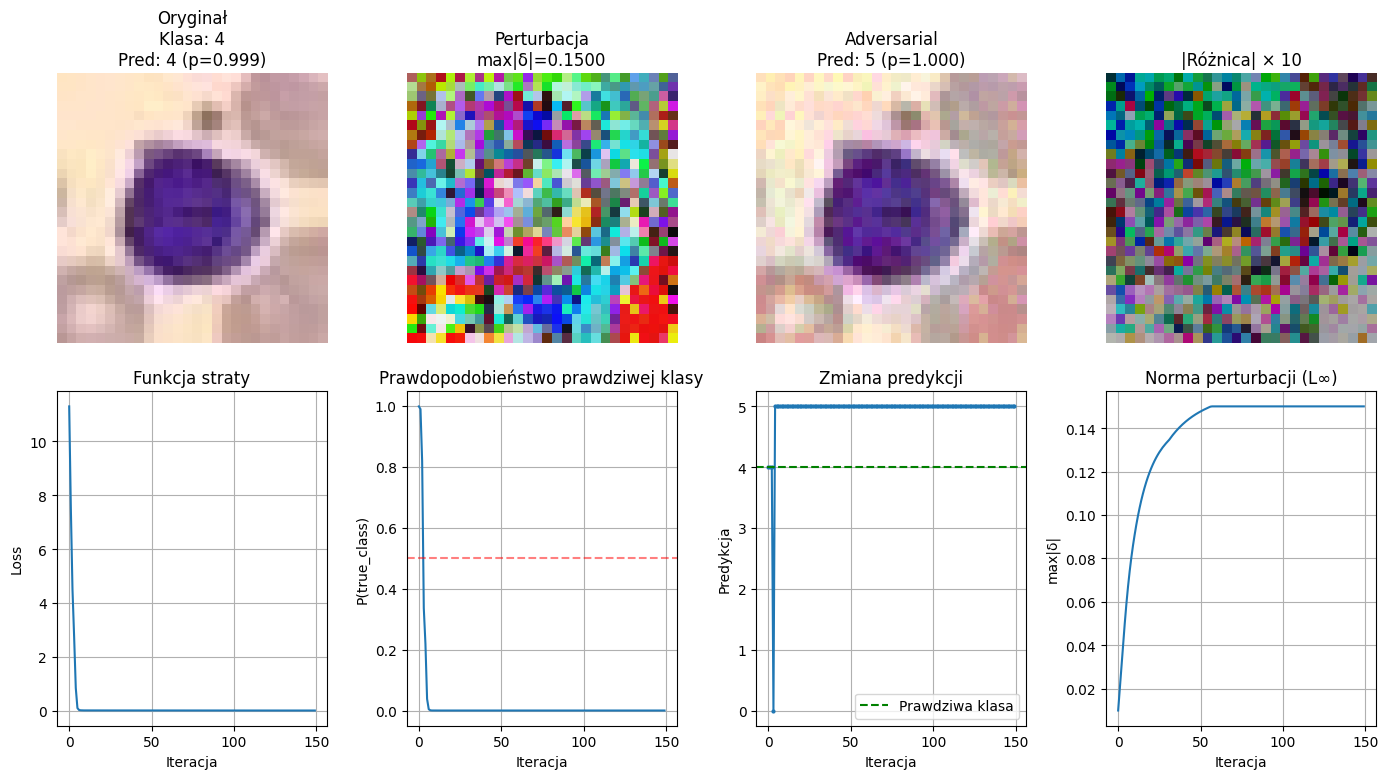

In [25]:
target_class = (true_label + 1) % n_classes

perturbation_t, adv_image_t, history_t = create_adversarial_perturbation(
    model=model,
    image=sample_image,
    true_class=true_label,
    epsilon=0.15,
    lr=0.01,
    num_iters=150,
    target_class=target_class
)

with torch.no_grad():
    logits_adv_t = model(adv_image_t)
    probs_adv_t = torch.softmax(logits_adv_t, dim=1)
    pred_adv_t = logits_adv_t.argmax(dim=1).item()
    prob_adv_t = probs_adv_t[0, pred_adv_t].item()

visualize_adversarial_attack(
    sample_image,
    adv_image_t,
    perturbation_t,
    true_label,
    pred_orig,
    pred_adv_t,
    prob_orig,
    prob_adv_t,
    history_t
)
